In [1]:
# ============================
# Cell 1: Imports & Settings
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("xgboost is not installed. XGBoost model will be skipped.")

import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.1)


In [2]:
# ============================
# Cell 2: Load Dataset
# ============================

df = pd.read_csv("Crop_recommendation.csv")
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
# ============================
# Cell 3: Basic Info & Null Check
# ============================

print("Dataset information:")
print(df.info())

print("\nSummary statistics:")
display(df.describe())

print("\nNumber of missing values in each column:")
print(df.isnull().sum())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

Summary statistics:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117



Number of missing values in each column:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


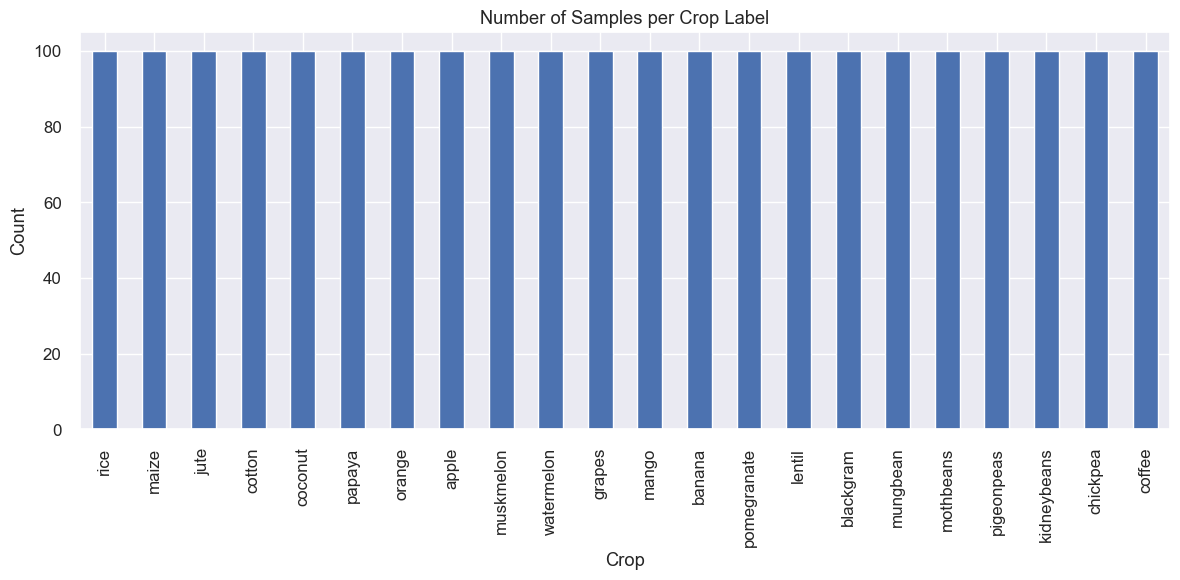

In [4]:
# ============================
# Cell 4: Target (Crop) Distribution
# ============================

plt.figure(figsize=(12, 6))
df['label'].value_counts().plot(kind='bar')
plt.title("Number of Samples per Crop Label")
plt.xlabel("Crop")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


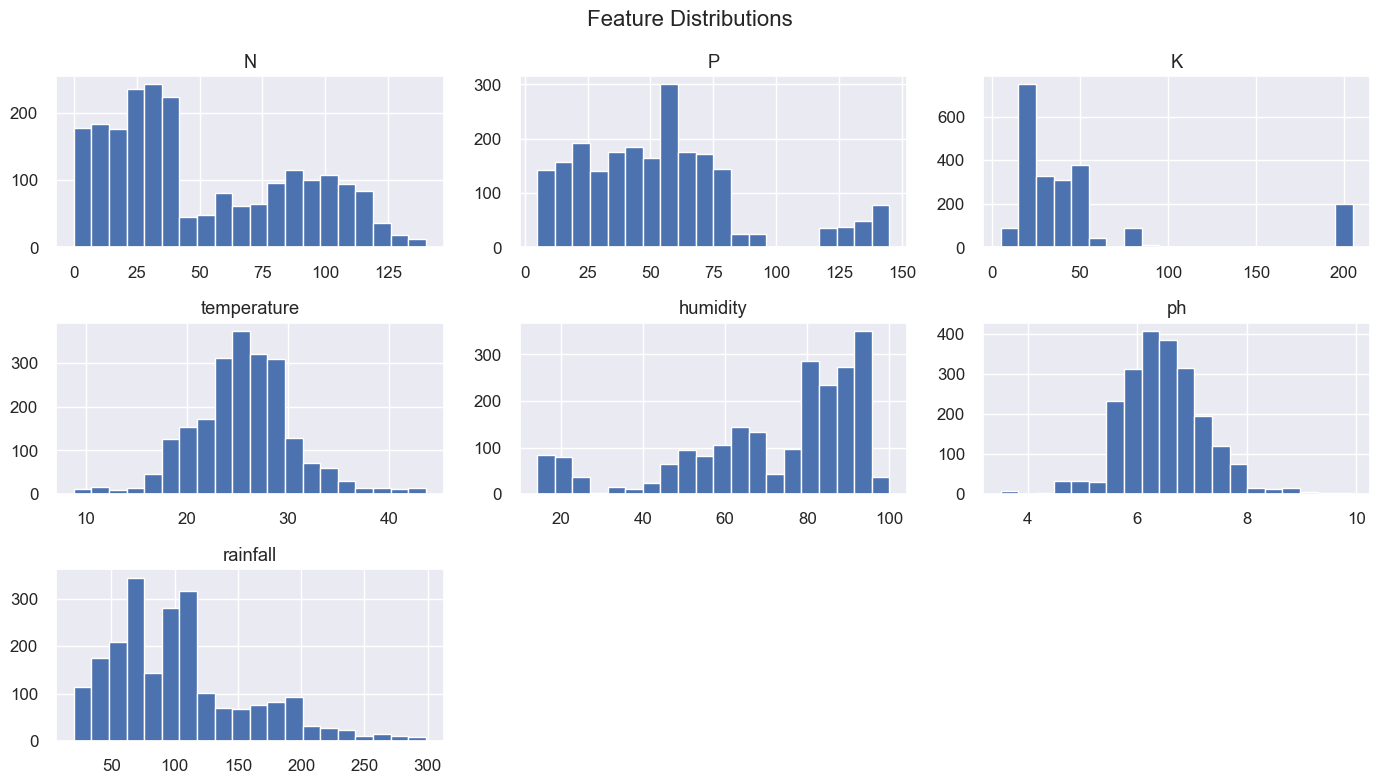

In [5]:
# ============================
# Cell 5: Feature Distributions (Histograms)
# ============================

feature_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

df[feature_cols].hist(figsize=(14, 8), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


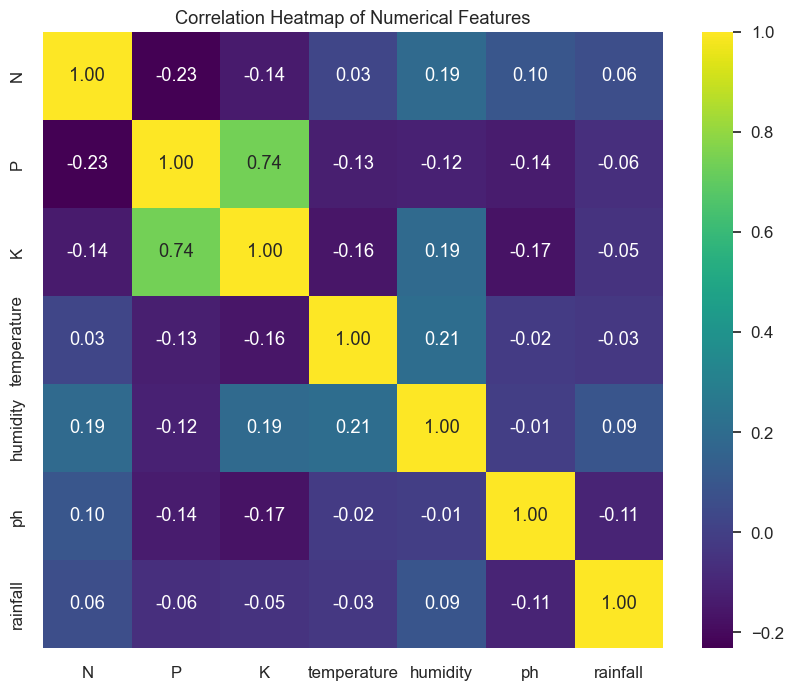

In [6]:
# ============================
# Cell 6: Correlation Heatmap
# ============================

plt.figure(figsize=(10, 8))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [ ]:
# ============================
# Cell 7: Pairplot (Optional - May be Slow)
# ============================

# Uncomment to view pairwise relationships (can be slow)
# sns.pairplot(df[feature_cols + ['label']], hue='label', corner=True)
# plt.show()


In [7]:
# ============================
# Cell 8: Prepare Features (X) and Encoded Target (y_encoded)
# ============================

X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['label']

# Label encode crop names to integers (needed for XGBoost and consistent ML handling)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Original labels example:", y.unique()[:5])
print("Encoded labels example:", y_encoded[:5])
print("Number of unique crops:", len(le.classes_))


Original labels example: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas']
Encoded labels example: [20 20 20 20 20]
Number of unique crops: 22


In [8]:
# ============================
# Cell 9: Train-Test Split
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 1540
Test set size: 660


In [9]:
# ============================
# Cell 10: Define Base Models
# ============================

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB()
}

if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )

models


{'RandomForest': RandomForestClassifier(random_state=42),
 'DecisionTree': DecisionTreeClassifier(random_state=42),
 'KNN': KNeighborsClassifier(),
 'NaiveBayes': GaussianNB(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, ...)}

In [10]:
# ============================
# Cell 11: Train & Evaluate Models
# ============================

results = []
predictions_dict = {}

for name, model in models.items():
    print("="*60)
    print(f"Training model: {name}")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    predictions_dict[name] = y_pred
    
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"Accuracy ({name}): {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(
        y_test,
        y_pred,
        target_names=le.classes_
    ))
    print("\n")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(
    by="Accuracy", ascending=False
)
results_df.reset_index(drop=True, inplace=True)
results_df


Training model: RandomForest
Accuracy (RandomForest): 0.9939

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        30
      banana       1.00      1.00      1.00        30
   blackgram       1.00      0.97      0.98        30
    chickpea       1.00      1.00      1.00        30
     coconut       1.00      1.00      1.00        30
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        30
      grapes       1.00      1.00      1.00        30
        jute       0.94      1.00      0.97        30
 kidneybeans       1.00      1.00      1.00        30
      lentil       1.00      0.97      0.98        30
       maize       0.97      1.00      0.98        30
       mango       1.00      1.00      1.00        30
   mothbeans       0.97      1.00      0.98        30
    mungbean       1.00      1.00      1.00        30
   muskmelon       1.00      1.00      1.00       

,Model,Accuracy
0,RandomForest,0.993939
1,NaiveBayes,0.992424
2,XGBoost,0.986364
3,DecisionTree,0.978788
4,KNN,0.978788


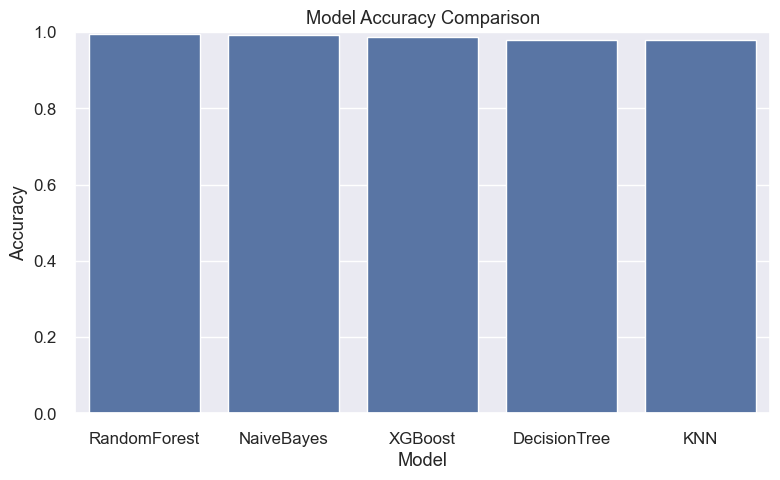

In [11]:
# ============================
# Cell 12: Accuracy Comparison Plot
# ============================

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


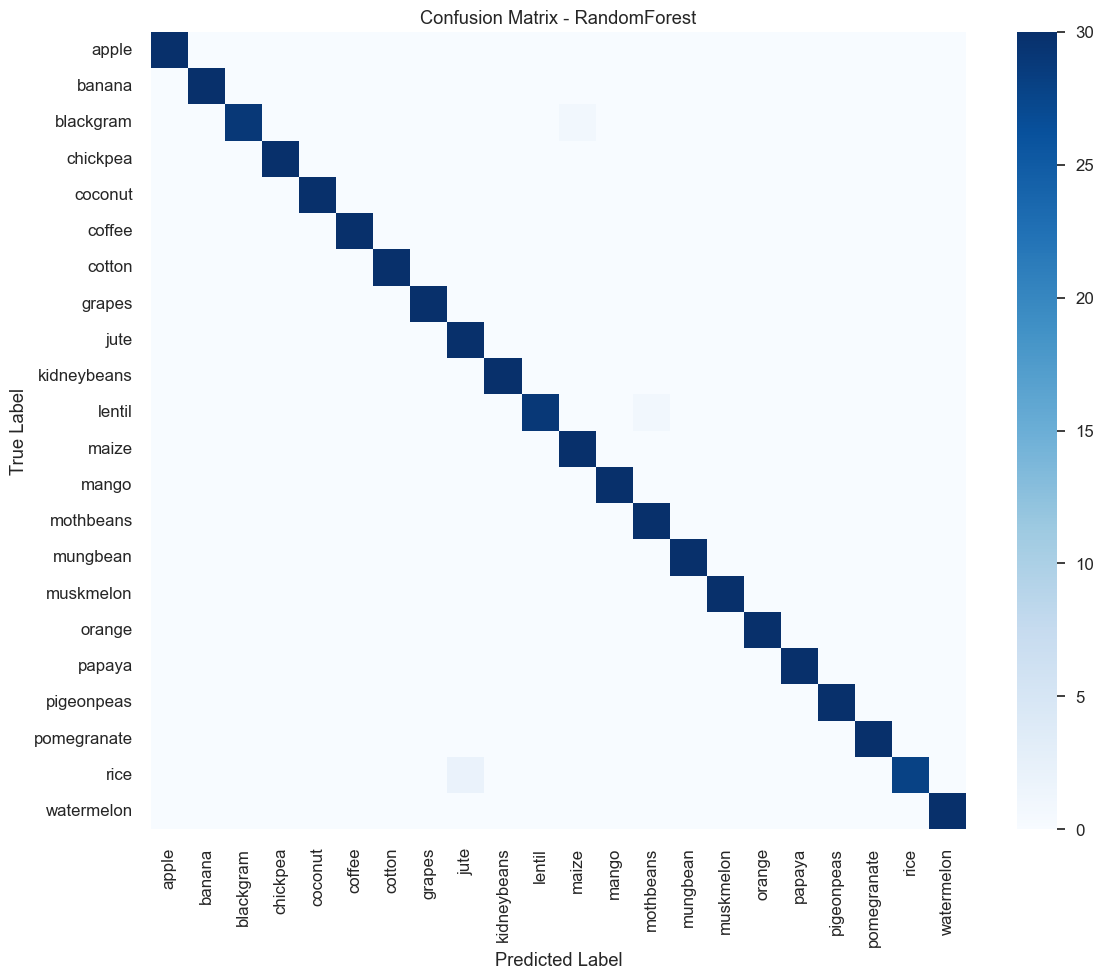

In [12]:
# ============================
# Cell 13: Confusion Matrix - RandomForest
# ============================

rf_model = models["RandomForest"]
y_pred_rf = predictions_dict["RandomForest"]

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("Confusion Matrix - RandomForest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


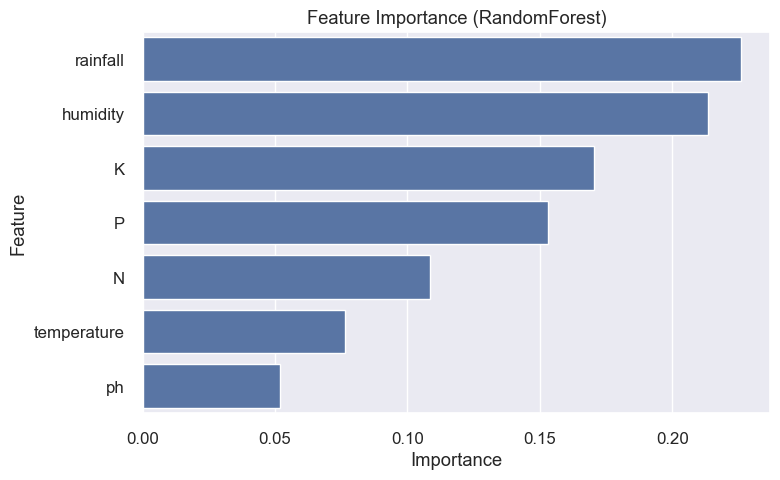

In [13]:
# ============================
# Cell 14: Feature Importance - RandomForest
# ============================

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature")
plt.title("Feature Importance (RandomForest)")
plt.tight_layout()
plt.show()


In [14]:
# ============================
# Cell 15: Hyperparameter Tuning - RandomForest
# ============================

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best parameters for RandomForest:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
best_rf_acc = accuracy_score(y_test, y_pred_best_rf)

print("\nTest Accuracy using Best RandomForest:", best_rf_acc)
print("\nClassification Report (Best RandomForest):")
print(classification_report(y_test, y_pred_best_rf, target_names=le.classes_))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best CV Accuracy: 0.9935022742040287

Test Accuracy using Best RandomForest: 0.9939393939393939

Classification Report (Best RandomForest):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        30
      banana       1.00      1.00      1.00        30
   blackgram       1.00      0.97      0.98        30
    chickpea       1.00      1.00      1.00        30
     coconut       1.00      1.00      1.00        30
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        30
      grapes       1.00      1.00      1.00        30
        jute       0.97      1.00      0.98        30
 kidneybeans       1.00      1.00      1.00        30
      lentil       1.00      0.93      0.97        30
       maize       0.97      1.00      0.98        3

In [15]:
# ============================
# Cell 16: Hyperparameter Tuning - KNN
# ============================

knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski"]
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best CV Accuracy:", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)
best_knn_acc = accuracy_score(y_test, y_pred_best_knn)

print("\nTest Accuracy using Best KNN:", best_knn_acc)
print("\nClassification Report (Best KNN):")
print(classification_report(y_test, y_pred_best_knn, target_names=le.classes_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for KNN: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Best CV Accuracy: 0.9753225476141716

Test Accuracy using Best KNN: 0.9787878787878788

Classification Report (Best KNN):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        30
      banana       1.00      1.00      1.00        30
   blackgram       0.94      1.00      0.97        30
    chickpea       1.00      1.00      1.00        30
     coconut       1.00      1.00      1.00        30
      coffee       1.00      1.00      1.00        30
      cotton       0.94      1.00      0.97        30
      grapes       1.00      1.00      1.00        30
        jute       0.85      0.93      0.89        30
 kidneybeans       0.97      1.00      0.98        30
      lentil       0.97      0.97      0.97        30
       maize       1.00      0.93      0.97        30
       mango       1.00  

In [16]:
# ============================
# Cell 17: Save Models as .pkl
# ============================

# 1. Save tuned RandomForest (trained on encoded labels)
with open("RandomForest_encoded.pkl", "wb") as f:
    pickle.dump(best_rf, f)
print("Saved tuned RandomForest model as RandomForest_encoded.pkl")

# 2. Save tuned KNN
with open("KNeighborsClassifier.pkl", "wb") as f:
    pickle.dump(best_knn, f)
print("Saved tuned KNN model as KNeighborsClassifier.pkl")

# 3. Save base models trained earlier (if needed)
with open("DecisionTree.pkl", "wb") as f:
    pickle.dump(models["DecisionTree"], f)

with open("NBClassifier.pkl", "wb") as f:
    pickle.dump(models["NaiveBayes"], f)

if 'XGBoost' in models:
    with open("XGBoost.pkl", "wb") as f:
        pickle.dump(models["XGBoost"], f)

# 4. Save LabelEncoder for future decoding of predictions
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("Saved label encoder as label_encoder.pkl")

# 5. Train a separate RandomForest on original string labels for existing Streamlit app
rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_text.fit(X, y)  # y is string labels

with open("RF.pkl", "wb") as f:
    pickle.dump(rf_text, f)

print("Saved RF.pkl (RandomForest trained on string labels) for Streamlit web app.")


Saved tuned RandomForest model as RandomForest_encoded.pkl
Saved tuned KNN model as KNeighborsClassifier.pkl
Saved label encoder as label_encoder.pkl
Saved RF.pkl (RandomForest trained on string labels) for Streamlit web app.


## Conclusion

- Performed exploratory data analysis (EDA) on the crop recommendation dataset.
- Visualized crop label distribution, feature distributions, and feature correlations.
- Encoded crop labels using `LabelEncoder` for compatibility with multiple ML models.
- Trained and evaluated several classifiers: RandomForest, DecisionTree, KNN, Naive Bayes, and optionally XGBoost.
- Compared models using accuracy scores and classification reports.
- Plotted a confusion matrix and feature importance for the RandomForest classifier.
- Performed hyperparameter tuning for RandomForest and KNN using `GridSearchCV`.
- Saved tuned models and a label encoder for future use.
- Additionally trained and saved a `RandomForest` model on original string labels as `RF.pkl` for compatibility with the existing Streamlit web application.
